In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import statsmodels.api as sm
import itertools

In [71]:
def drop_columns(thresh, data):
    for var in data:
        if data[var].isna().sum() > thresh:
            data = data.drop(var, axis=1)
            
    return data

In [72]:
def load_peace_sys_data():
    df = pd.DataFrame(pd.read_csv('revised_peace_sys.csv', index_col=0, na_values=['(NA)']))
    return df

In [73]:
def get_odds_ratios(coefs):
    return np.exp(coefs[0])


In [74]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    # first index refers to proba that belongs to class 0
    # second index refers to proba that belongs to calss 1
    p = model.predict_proba(x) # return matrix (N,2)
    # number of samples
    n = len(p)
    # number of features + 1 
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]]) # put intercept and coefs in same array
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1)) # 
    ans = np.zeros((m, m))
    for i in range(n):
        # dot product of transposed row and row
        # then multiply by both probas
        # add it to ans
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    # acovariance matrix
    vcov = np.linalg.inv(np.matrix(ans))
    # square root diagonal of covariace matrix
    se = np.sqrt(np.diag(vcov))
    # divide coefs by standard error
    t =  coefs/se 
    # two tailed using normal dist
    p = (1 - stats.norm.cdf(abs(t))) * 2
    return p

In [75]:
def logit_with_nan(data):
    data_copy = data.drop('PSys', axis=1)
    pvalues = []
    logit_beta = []
    logit_odds_ratio = []

    
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        
        y = X.PSys
        X = X.drop('PSys', axis=1)
        logreg = LogisticRegression(random_state=42, C=1e9)
        logreg.fit(X, y)
        pvalue = logit_pvalue(logreg, X)[1]
        
        pvalues.append(pvalue)
        
        beta = np.absolute(logreg.coef_[0][0])
        logit_beta.append(beta)
        logit_odds_ratio.append(np.exp(beta))
        
        
    res = pd.DataFrame({'Variable' : data_copy.columns,
                        'Logistic_Sig_Level' : pvalues,
                        'Logistic_Beta' : logit_beta,
                        'Logistic_Odds_Ratio' : logit_odds_ratio
                       })
    
    res = res.set_index('Variable')
    
    return res

In [76]:
def compute_ttest(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 't_statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        ttest = stats.ttest_ind(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             't_statistic' : ttest.statistic, 
                             'p_value' : [ttest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [77]:
def ttest_with_nan(data):
    """ 
    This is a two sided test for the null hypothesis that 2 independent samples
    have identical average(expected) values.
    
    Test assusmes that the populations have identical variances by default
    
    Parameters
    ----------
    data: DataFrame
        The DataFrame that contains Nan values
        
    Returns
    -------
    returns DataFrame that contains statistic and pvalue for every column in data
    
    t_statistic: float
        Calculated t-statistic
    
    p_value: float
        Two tailed p-value
            
    """
    # create a copy that excludes target variable
    data_copy = data.drop('PSys', axis=1)
    # prepare result data frame
    res_df = pd.DataFrame(columns=['Variable', 't_statistic', 'ttest_p_value'])
    # for every label, we separate each row by what its target value is
    # we drop the nan values
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        # filter peaceful 
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        
        non_peaceful = X[X.PSys == 0]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculate two-sided ttest
        ttest_result = stats.ttest_ind(peaceful, non_peaceful)
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 't_statistic' : ttest_result.statistic,
                                 'ttest_p_value' : ttest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [78]:
def compute_mannwhitneyu(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 'statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        utest = stats.mannwhitneyu(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             'statistic' : utest.statistic, 
                             'p_value' : [utest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [79]:
def mannwhitneyu_with_nan(data):
    """ 
    Computes the Mann-Whitney rank test on each of the columns of data
    Each column is seperated into 2 different arrays
    
    One group is peaceful, the other group is non-peaceful
    
    Parameters
    ----------
    data : DataFrame
        DataFrame that contains nan values
        
    Returns:
    -------
    Retures a DataFrame with U_statistic and Pvalue for every column
    
    U_statististic: float
        Mann-Whitney U statistic, equal to min(U for x, and U for y)
        
    p_value: float
        p-value assuming asymptotic normal distribution. Two-Sided.
    """
    data_copy = data.drop('PSys', axis=1)
    res_df = pd.DataFrame(columns=['Variable', 'U_statistic', 'mannwhitneyu_p_value'])
    for label in data_copy.columns:
        # isolate the target variable and current variable
        X = data[[label, 'PSys']]
        # drop all Nan values
        X = X.dropna()
        # filter out peaceful rows
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        # filter out non peaceful rows
        non_peaceful = X[X.PSys == 0]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculates two-sided Mann-Whitney U test
        utest_result = stats.mannwhitneyu(peaceful, non_peaceful, alternative='two-sided')
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 'U_statistic' : utest_result.statistic,
                                 'mannwhitneyu_p_value' : utest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [80]:
peace_sys = load_peace_sys_data()

peace_sys

,SCCS,Coder,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,107,KA,9.0,2.0,3,9.0,9,9,9,9,...,9.0,9.00,9.000000,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,108,EC,1.0,9.0,9,1.0,9,9,9,9,...,9.0,9.00,9.000000,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,135,"KA, EC",9.0,9.0,9,9.0,9,9,1,1,...,9.0,2.50,9.000000,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,154,KA,9.0,3.0,9,3.0,9,9,9,3,...,9.0,9.00,9.000000,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,35,KA,9.0,2.0,3,4.0,9,4,9,2,...,9.0,3.50,9.000000,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,157,DG,9.0,2.0,2,9.0,9,9,9,9,...,9.0,3.00,9.000000,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,23,DG,1.0,2.0,4,9.0,1,3,3,9,...,9.0,9.00,9.000000,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,54,DG,4.0,9.0,1,9.0,9,9,9,9,...,9.0,9.00,9.000000,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,109,DG,3.0,9.0,4,4.0,3,9,3,9,...,9.0,9.00,9.000000,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [81]:
peace_sys = peace_sys.drop(['SCCS','Coder', 'PSysRec'], axis=1)

In [82]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,9.0,2.0,3,9.0,9,9,9,9,9.0,9.0,...,9.0,9.00,9.000000,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,9.0,9,1.0,9,9,9,9,3.0,4.0,...,9.0,9.00,9.000000,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,9.0,9.0,9,9.0,9,9,1,1,1.0,2.5,...,9.0,2.50,9.000000,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,9.0,3.0,9,3.0,9,9,9,3,3.0,3.0,...,9.0,9.00,9.000000,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,9.0,2.0,3,4.0,9,4,9,2,3.0,3.0,...,9.0,3.50,9.000000,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,9.0,2.0,2,9.0,9,9,9,9,9.0,2.0,...,9.0,3.00,9.000000,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4,9.0,1,3,3,9,2.0,4.0,...,9.0,9.00,9.000000,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,9.0,1,9.0,9,9,9,9,9.0,9.0,...,9.0,9.00,9.000000,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,9.0,4,4.0,3,9,3,9,3.0,3.0,...,9.0,9.00,9.000000,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [83]:
peace_sys = peace_sys.replace(9, np.nan)

In [84]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.50,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.50,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.00,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [85]:
peace_sys = drop_columns(peace_sys.shape[0] - 4, peace_sys)

In [86]:
peace_sys.head(10)

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMmrs,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.5,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.5,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.0,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [87]:
peace_sys['PSys'] = peace_sys['PSys'].replace(2, 0)

In [88]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMmrs,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.50,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.50,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.00,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [89]:
VARS = ['NWNorm5.1_1', 'RitP6_1', 'Dep3.3Econ_1', 'NWVal4.1_1',
        'Int2.4Hist_1', 'ID1.1Over_1', 'Lead9.1P_1', 'Int2.2Econ_1', 
        'Dep3.2Ecol_1', 'CM8.5Peace_1', 'SymP6_1', 'Dep3.1Sec_1', 'SuperOrd7_1', 'PSys'] 

In [90]:
# Actual name of vars
VARS_DECODED  = ['NonWarring Norms', 'NonWarring Rituals', 'Economic Interdependence',
                 'NonWarring Values', 'Historical Interconnections', 'Overarching Identity', 
                 'Peace Leadership', 'Economic Interconnectedness', 'Ecological Interdependence', 
                'Conflict Management', 'Peace Symbols', 'Security Interdependence', 'Superordinate Institutions']

In [91]:
# check all variables are inputed. Not incliding PSys in vars
len(VARS) - 1 == len(VARS_DECODED)

True

In [92]:
X = peace_sys[VARS].drop('PSys', axis=1)
X = X.fillna(X.mean())

In [93]:
X

,NWNorm5.1_1,RitP6_1,Dep3.3Econ_1,NWVal4.1_1,Int2.4Hist_1,ID1.1Over_1,Lead9.1P_1,Int2.2Econ_1,Dep3.2Ecol_1,CM8.5Peace_1,SymP6_1,Dep3.1Sec_1,SuperOrd7_1
Name,,,,,,,,,,,,,
Gilbertese,3.083333,2.565217,2.689655,3.171875,2.913043,2.532258,2.764706,2.984375,2.5,3.1,2.923077,2.5,2.625
Marshallese,3.083333,2.000000,3.000000,4.000000,2.913043,1.000000,2.764706,1.000000,2.5,3.1,2.000000,2.5,2.625
E. Pomo,3.083333,2.565217,1.000000,2.500000,2.913043,2.532258,2.000000,2.984375,1.0,3.1,2.923077,1.0,2.625
Popoluca,3.083333,2.565217,3.000000,3.000000,2.913043,2.532258,2.764706,3.000000,3.0,3.1,2.923077,2.5,2.625
Konso,3.083333,2.565217,3.000000,3.000000,4.000000,2.532258,2.764706,4.000000,2.0,3.1,3.000000,2.5,2.625
Bribri,2.000000,2.565217,2.689655,2.000000,2.913043,2.532258,2.764706,2.984375,2.5,3.1,2.923077,2.5,2.000
Tallensi,3.000000,2.565217,2.000000,4.000000,3.000000,1.000000,2.764706,2.984375,2.5,2.0,2.923077,3.0,1.000
Russians,3.083333,2.565217,2.689655,3.171875,2.913043,4.000000,1.000000,2.984375,2.5,2.0,2.923077,2.5,2.000
Trukese,3.000000,2.000000,3.000000,3.000000,2.913043,3.000000,2.764706,4.000000,2.5,3.1,2.923077,3.0,3.000


In [94]:
X.isna().sum().sum()

0

In [95]:
len(peace_sys.columns)

74

In [96]:
y = peace_sys.PSys

# Logistic Regression

In [97]:
logit_results = logit_with_nan(peace_sys[VARS])

In [98]:
logit_results

,Logistic_Sig_Level,Logistic_Beta,Logistic_Odds_Ratio
Variable,,,
NWNorm5.1_1,0.000539,3.267758,26.252419
RitP6_1,0.011390,2.546314,12.759978
Dep3.3Econ_1,0.005948,2.375179,10.752935
NWVal4.1_1,0.008301,1.681373,5.372928
Int2.4Hist_1,0.015064,2.040491,7.694385
ID1.1Over_1,0.005739,1.514855,4.548760
Lead9.1P_1,0.057420,1.024079,2.784529
Int2.2Econ_1,0.014101,1.220465,3.388763
Dep3.2Ecol_1,0.025693,1.057162,2.878192


# T-Test

In [99]:
ttest = ttest_with_nan(peace_sys[VARS])

In [100]:
ttest

,t_statistic,ttest_p_value
Variable,,
NWNorm5.1_1,4.507533,0.000048
RitP6_1,3.630994,0.000733
Dep3.3Econ_1,3.972121,0.000260
NWVal4.1_1,3.109278,0.003285
Int2.4Hist_1,2.948822,0.005091
ID1.1Over_1,3.461848,0.001206
Lead9.1P_1,2.053967,0.045950
Int2.2Econ_1,2.829371,0.007000
Dep3.2Ecol_1,2.524637,0.015263


# Mann-Whitney U-Test

In [101]:
mannwhitneyu = mannwhitneyu_with_nan(peace_sys[VARS])

In [102]:
mannwhitneyu

,U_statistic,mannwhitneyu_p_value
Variable,,
NWNorm5.1_1,417.5,0.000012
RitP6_1,398.5,0.000089
Dep3.3Econ_1,370.0,0.001957
NWVal4.1_1,373.5,0.001420
Int2.4Hist_1,388.0,0.000246
ID1.1Over_1,363.5,0.003544
Lead9.1P_1,328.0,0.019354
Int2.2Econ_1,371.5,0.001808
Dep3.2Ecol_1,329.5,0.028761


#  Random Forest

In [103]:
rfc = RandomForestClassifier(random_state=42, n_estimators=2000).fit(X, y)

In [104]:
rfc_feature_importances = pd.DataFrame({'Variables' : X.columns, 'rfc_feature_importance' : rfc.feature_importances_})
rfc_feature_importances = rfc_feature_importances.set_index('Variables')

In [105]:
rfc_feature_importances

,rfc_feature_importance
Variables,
NWNorm5.1_1,0.212815
RitP6_1,0.110128
Dep3.3Econ_1,0.077020
NWVal4.1_1,0.094577
Int2.4Hist_1,0.073660
ID1.1Over_1,0.049794
Lead9.1P_1,0.053476
Int2.2Econ_1,0.052339
Dep3.2Ecol_1,0.046069


# Putting Everything Together

In [106]:
all_methods = pd.DataFrame({
    'Random_Forest': rfc_feature_importances['rfc_feature_importance'],
    'MannWhitneyU_Test' : mannwhitneyu['mannwhitneyu_p_value'],
    'T_Test' : ttest['ttest_p_value'],
    'Logistic_Regression' : logit_results['Logistic_Sig_Level'],
    'Log_Random_Forest' : ((rfc_feature_importances['rfc_feature_importance'])/(rfc_feature_importances['rfc_feature_importance'].mean())) * np.log10(1/0.05),
    'Log_MannWhitneyU_Test' : np.log10(1 / (mannwhitneyu['mannwhitneyu_p_value'])),
    'Log_T_Test' : np.log10(1 / ttest['ttest_p_value']),
    'Log_Logistic_Regression' : np.log10(1 / (logit_results['Logistic_Sig_Level']))
},)

In [107]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression
NWNorm5.1_1,0.212815,0.000012,0.000048,0.000539,3.599427,4.935880,4.317899,3.268303
RitP6_1,0.110128,0.000089,0.000733,0.011390,1.862644,4.051817,3.135066,1.943483
Dep3.3Econ_1,0.077020,0.001957,0.000260,0.005948,1.302671,2.708502,3.584217,2.225619
NWVal4.1_1,0.094577,0.001420,0.003285,0.008301,1.599610,2.847636,2.483507,2.080860
Int2.4Hist_1,0.073660,0.000246,0.005091,0.015064,1.245833,3.608481,2.293173,1.822059
ID1.1Over_1,0.049794,0.003544,0.001206,0.005739,0.842183,2.450450,2.918747,2.241166
Lead9.1P_1,0.053476,0.019354,0.045950,0.057420,0.904458,1.713219,1.337715,1.240935
Int2.2Econ_1,0.052339,0.001808,0.007000,0.014101,0.885230,2.742862,2.154901,1.850742
Dep3.2Ecol_1,0.046069,0.028761,0.015263,0.025693,0.779188,1.541199,1.816370,1.590184
CM8.5Peace_1,0.027657,0.003941,0.011228,0.024945,0.467768,2.404448,1.949694,1.603022


In [108]:
log_columns = ['Log_Logistic_Regression',  
                                     'Log_T_Test', 
                                     'Log_MannWhitneyU_Test', 
                                     'Log_Random_Forest']

In [109]:
all_methods['LOG_SUM'] = all_methods[log_columns].sum(axis=1)

In [110]:
all_methods['LOG_PRODUCT'] = all_methods[log_columns].product(axis=1)

In [111]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1_1,0.212815,0.000012,0.000048,0.000539,3.599427,4.935880,4.317899,3.268303,16.121510,250.722268
RitP6_1,0.110128,0.000089,0.000733,0.011390,1.862644,4.051817,3.135066,1.943483,10.993010,45.984053
Dep3.3Econ_1,0.077020,0.001957,0.000260,0.005948,1.302671,2.708502,3.584217,2.225619,9.821009,28.145502
NWVal4.1_1,0.094577,0.001420,0.003285,0.008301,1.599610,2.847636,2.483507,2.080860,9.011614,23.540031
Int2.4Hist_1,0.073660,0.000246,0.005091,0.015064,1.245833,3.608481,2.293173,1.822059,8.969546,18.783797
ID1.1Over_1,0.049794,0.003544,0.001206,0.005739,0.842183,2.450450,2.918747,2.241166,8.452545,13.499652
Lead9.1P_1,0.053476,0.019354,0.045950,0.057420,0.904458,1.713219,1.337715,1.240935,5.196327,2.572255
Int2.2Econ_1,0.052339,0.001808,0.007000,0.014101,0.885230,2.742862,2.154901,1.850742,7.633735,9.683523
Dep3.2Ecol_1,0.046069,0.028761,0.015263,0.025693,0.779188,1.541199,1.816370,1.590184,5.726941,3.468586
CM8.5Peace_1,0.027657,0.003941,0.011228,0.024945,0.467768,2.404448,1.949694,1.603022,6.424932,3.515216


In [112]:
all_methods['LOG_SUM'][np.argsort(all_methods['LOG_SUM'])][::-1]

NWNorm5.1_1     16.121510
RitP6_1         10.993010
Dep3.3Econ_1     9.821009
NWVal4.1_1       9.011614
Int2.4Hist_1     8.969546
ID1.1Over_1      8.452545
Int2.2Econ_1     7.633735
SymP6_1          6.858782
CM8.5Peace_1     6.424932
Dep3.2Ecol_1     5.726941
Lead9.1P_1       5.196327
Dep3.1Sec_1      4.913164
SuperOrd7_1      4.133834
Name: LOG_SUM, dtype: float64

In [113]:
log_product_sorted_indices = np.argsort(all_methods['LOG_PRODUCT'])[::-1]

In [114]:
all_methods['LOG_PRODUCT'][log_product_sorted_indices]

NWNorm5.1_1     250.722268
RitP6_1          45.984053
Dep3.3Econ_1     28.145502
NWVal4.1_1       23.540031
Int2.4Hist_1     18.783797
ID1.1Over_1      13.499652
Int2.2Econ_1      9.683523
SymP6_1           4.451130
CM8.5Peace_1      3.515216
Dep3.2Ecol_1      3.468586
Lead9.1P_1        2.572255
Dep3.1Sec_1       2.116149
SuperOrd7_1       1.024404
Name: LOG_PRODUCT, dtype: float64

In [115]:
log_sum_sorted_indices = np.argsort(all_methods['LOG_SUM'].values)[::-1]

In [116]:
all_methods['LOG_SUM'][log_sum_sorted_indices]

NWNorm5.1_1     16.121510
RitP6_1         10.993010
Dep3.3Econ_1     9.821009
NWVal4.1_1       9.011614
Int2.4Hist_1     8.969546
ID1.1Over_1      8.452545
Int2.2Econ_1     7.633735
SymP6_1          6.858782
CM8.5Peace_1     6.424932
Dep3.2Ecol_1     5.726941
Lead9.1P_1       5.196327
Dep3.1Sec_1      4.913164
SuperOrd7_1      4.133834
Name: LOG_SUM, dtype: float64

In [117]:
methods_names = ['Logistic Regression',  'T-Test', 'Mann Whitney U-Test', 'Random Forest']

In [118]:
methods_srted_logsum = all_methods.sort_values(by=['LOG_SUM'], ascending=False)

methods_srted_logsum.to_excel('methods_sorted_logsum.xlsx')

In [119]:
methods_srted_logsum

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1_1,0.212815,0.000012,0.000048,0.000539,3.599427,4.935880,4.317899,3.268303,16.121510,250.722268
RitP6_1,0.110128,0.000089,0.000733,0.011390,1.862644,4.051817,3.135066,1.943483,10.993010,45.984053
Dep3.3Econ_1,0.077020,0.001957,0.000260,0.005948,1.302671,2.708502,3.584217,2.225619,9.821009,28.145502
NWVal4.1_1,0.094577,0.001420,0.003285,0.008301,1.599610,2.847636,2.483507,2.080860,9.011614,23.540031
Int2.4Hist_1,0.073660,0.000246,0.005091,0.015064,1.245833,3.608481,2.293173,1.822059,8.969546,18.783797
ID1.1Over_1,0.049794,0.003544,0.001206,0.005739,0.842183,2.450450,2.918747,2.241166,8.452545,13.499652
Int2.2Econ_1,0.052339,0.001808,0.007000,0.014101,0.885230,2.742862,2.154901,1.850742,7.633735,9.683523
SymP6_1,0.028637,0.005935,0.003230,0.022024,0.484341,2.226564,2.490774,1.657103,6.858782,4.451130
CM8.5Peace_1,0.027657,0.003941,0.011228,0.024945,0.467768,2.404448,1.949694,1.603022,6.424932,3.515216
Dep3.2Ecol_1,0.046069,0.028761,0.015263,0.025693,0.779188,1.541199,1.816370,1.590184,5.726941,3.468586


In [120]:
methods_srted_logproduct = all_methods.sort_values(by=['LOG_PRODUCT'], ascending=False)
methods_srted_logproduct.to_excel('methods_sorted_logproduct.xlsx')

In [121]:
methods_srted_logproduct

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1_1,0.212815,0.000012,0.000048,0.000539,3.599427,4.935880,4.317899,3.268303,16.121510,250.722268
RitP6_1,0.110128,0.000089,0.000733,0.011390,1.862644,4.051817,3.135066,1.943483,10.993010,45.984053
Dep3.3Econ_1,0.077020,0.001957,0.000260,0.005948,1.302671,2.708502,3.584217,2.225619,9.821009,28.145502
NWVal4.1_1,0.094577,0.001420,0.003285,0.008301,1.599610,2.847636,2.483507,2.080860,9.011614,23.540031
Int2.4Hist_1,0.073660,0.000246,0.005091,0.015064,1.245833,3.608481,2.293173,1.822059,8.969546,18.783797
ID1.1Over_1,0.049794,0.003544,0.001206,0.005739,0.842183,2.450450,2.918747,2.241166,8.452545,13.499652
Int2.2Econ_1,0.052339,0.001808,0.007000,0.014101,0.885230,2.742862,2.154901,1.850742,7.633735,9.683523
SymP6_1,0.028637,0.005935,0.003230,0.022024,0.484341,2.226564,2.490774,1.657103,6.858782,4.451130
CM8.5Peace_1,0.027657,0.003941,0.011228,0.024945,0.467768,2.404448,1.949694,1.603022,6.424932,3.515216
Dep3.2Ecol_1,0.046069,0.028761,0.015263,0.025693,0.779188,1.541199,1.816370,1.590184,5.726941,3.468586


In [122]:
marker = itertools.cycle(('^', 'D', 'o', '*')) 

<Figure size 432x288 with 0 Axes>

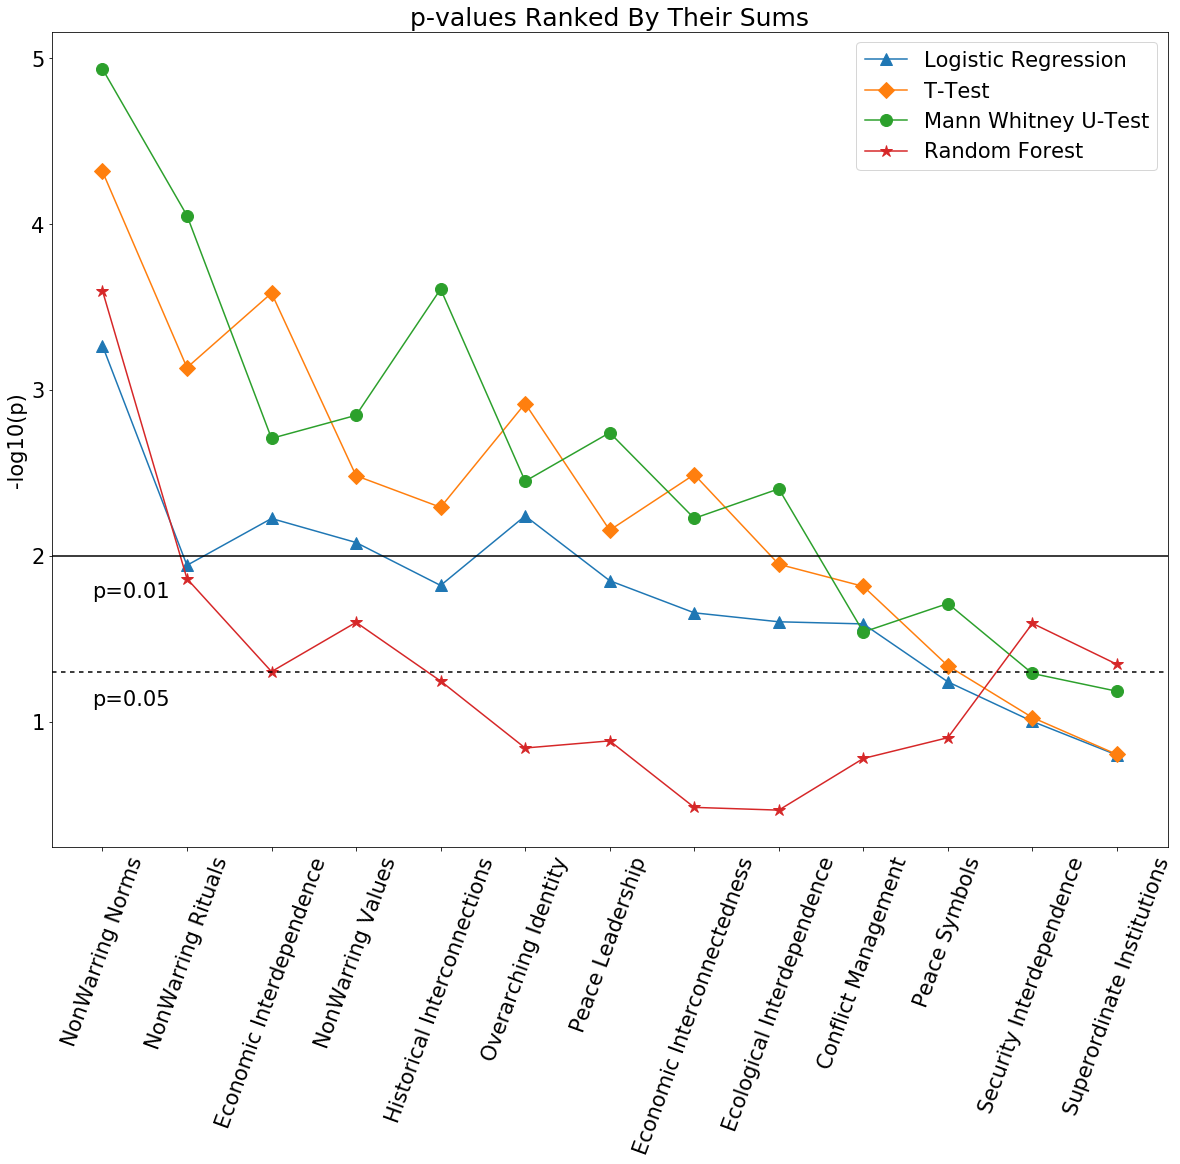

In [127]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Sums')

for col in methods_srted_logsum[log_columns].columns:
        plt.plot(methods_srted_logsum[col], marker=next(marker), markersize=12)
    
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(0.8, 1.75, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(0.8, 1.10, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), VARS_DECODED, rotation=70)
# plt.locator_params(axis='x', nbins=20)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('sum.png', quality=95, bbox_inches="tight")
plt.show()

<Figure size 432x288 with 0 Axes>

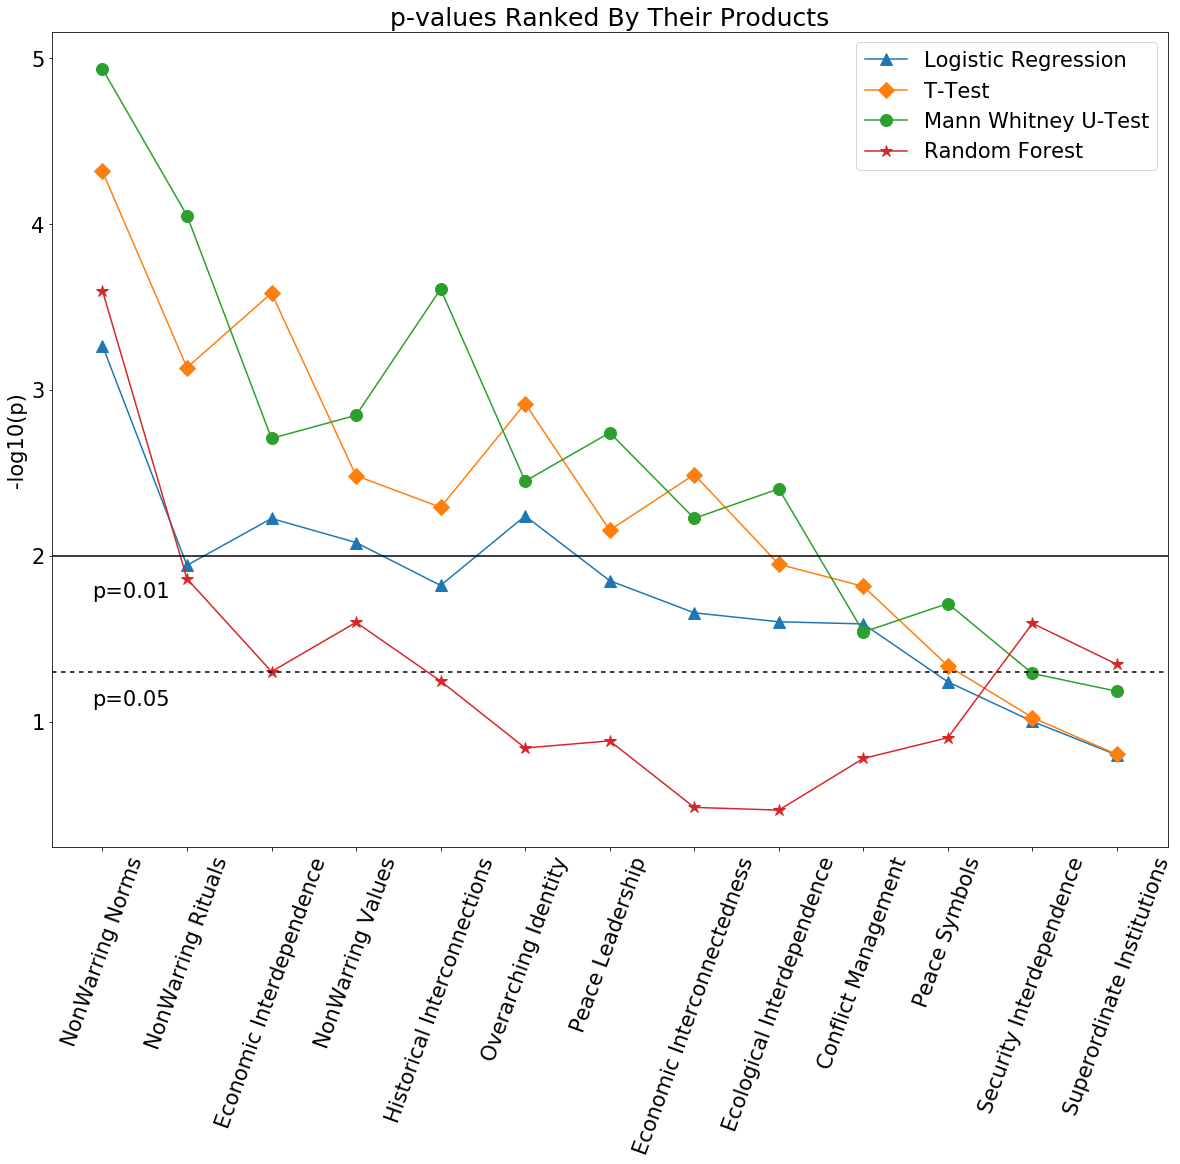

In [128]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Products')

for col in methods_srted_logproduct[log_columns].columns:
        plt.plot(methods_srted_logproduct[col], marker=next(marker), markersize=12)
 
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(0.8, 1.75, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(0.8, 1.10, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), VARS_DECODED, rotation=70)
# plt.locator_params(axis='x', nbins=20)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('product.png', quality=95, bbox_inches="tight")
plt.show()